# Build file creation of a honeycomb pattern <img align="right" width="192" height="64" src="https://freemelt.com/app/uploads/freemeltLogo-1.png">

Honeycomb patterns have numerous applications throughout science and engineering due to their low density, high strength and large surface area. Due to the high amount of control of the process, electron beam melting is well suited for developing honeycomb patterns, and this interactive guide will show how this can be done. 

Freemelt has an open source approach at its core. This includes the build file creation using Python (this guide is written using version 3.11.4 and requires `pip` to be installed), which is done using the Open Beam Path library `obplib`, the documentation for which may be found [here](https://gitlab.com/freemelt/openmelt/obplib-python/-/tree/master/obplib). Assuming that Python is installed and the environmental variables are correctly configured, installation is done by running 

In [187]:
#%pip install obplib

In [188]:
#%pip install jdc

from a command line interpreter of choice . The `obplib` library has to be imported through adding the line 

In [189]:
import obplib as obp
import jdc #utility package for this guide

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import copy
import matplotlib.style as mplstyle
mplstyle.use(['dark_background', 'fast'])
plt.rcParams['figure.dpi'] = 400
from matplotlib.collections import LineCollection

TEMPORARY: WILL HOPEFULLY BE INTEGRATED INTO .OBP PACKAGE

In [190]:
def plotty(lines, line_number, upper_lim):
    x_values = [[copy.copy(lines[i].P1.x), copy.copy(lines[i].P2.x)] for i in range(upper_lim)]
    y_values = [[copy.copy(lines[i].P1.y), copy.copy(lines[i].P2.y)] for i in range(upper_lim)]
    min_lines = max(upper_lim - line_number, 0)
    
    line_segments = [[(x_values[i][0], y_values[i][0]), (x_values[i][1], y_values[i][1])] for i in range(min_lines, upper_lim)]
    
    # Create an array of speed values for each line
    speeds = [lines[i].Speed for i in range(min_lines, upper_lim)]
    
    spot_sizes = [lines[i].bp.spot_size for i in range(min_lines, upper_lim)]
    
    line_collection = LineCollection(line_segments, cmap='Wistia_r', linewidth=2)
    line_collection.set_array(np.array(speeds))
    line_collection.set_linestyle('-')
    
    linewidths = np.array(spot_sizes) * 0.01  # Scale linewidths based on spot_size parameter
    
    line_collection.set_linewidth(linewidths)
    
    plt.gca().add_collection(line_collection)
    plt.colorbar(line_collection)

    last_x_values = x_values[-1]
    last_y_values = y_values[-1]
    plt.scatter(last_x_values[-1], last_y_values[-1], color='w', marker='*', s=spot_sizes[-1], zorder=10)
    
    plt.autoscale()
    plt.grid(False)
    plt.show()

def interactive_viewer(lines):
    line_number = widgets.IntText(value=len(lines), description='Max Lines:', min=1, max=len(lines))
    widgets.interact(plotty, lines=widgets.fixed(lines), upper_lim=(1, len(lines), 1), line_number=line_number, layout=widgets.Layout(width='50%'), continuous_update=True)

at the top of the Python file. With these preparatory steps finished, the actual build file creation can begin. Henceforth, just as is done with the code line above, `obplib` will be abbreviated as `obp`.

A honeycomb pattern is made up of regular hexagons of side length $s$ and interior angles of $2\pi/3$. Using trigonometry, the smaller width $a$ is calculated to $\sqrt{3}s$ and the larger width $A$ to $2s$. 

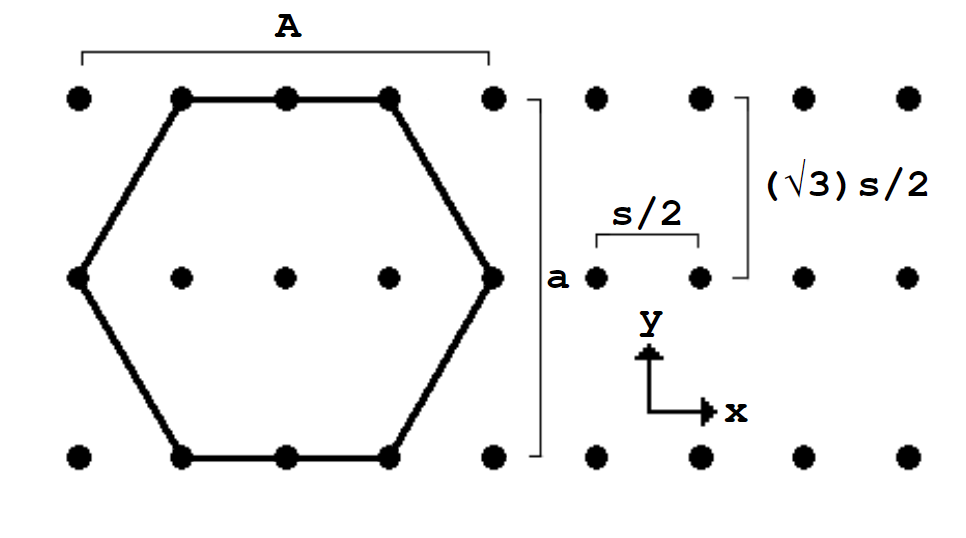

The approach here is to start with the basic `obp` objects and gradually working up to a functional build file. It contains quite a bit of code, but much of it is repeated with slight additions in order to keep complexity jumps manageable. 

To start, the hexagonal lattice is represented by a class:

In [191]:
class Honeycomb:
    def __init__(self, dimensions, center_point, side_length, speed, spot_size, power):
        self.dimensions = dimensions #array that stores width (x direction) and height (y direction) of the desired component.
        self.center_point = center_point #array that stores the center point of the component
        self.side_length = side_length #side length of the hexagon
        self.speed = speed #speed of the beam
        self.spot_size = spot_size #size of the beam spot
        self.power = power #power of the beam

 To create a hexagonal pattern, a grid of `Point`'s is created. A `Point` is an `obp` object storing the Cartesian coordinates (`x`, `y`) of a point in the plane. 

In [192]:
x = 1
y = 2
p = obp.Point(x, y)
print("x = ", p.x, ", y = ", p.y)

x =  1 , y =  2


If the hexagons are oriented such that the larger width $A$ is horizontal to the `x` axis, it follows from trigonometry that the grid should have a spacing of $s/2$ in the `x` direction and $\sqrt{3}s/2$ in the `y` direction. The private method `_place_points` populates the grid with `Point` objects:

In [193]:
%%add_to Honeycomb
def _place_points(self):
        TOL = 1e-2 #user defined tolerance parameter
        hex_number = [0, 0] #number of hexagons that fit into the dimensions in the x and y directions, respectively
        
        #compares given side length to the dimensional constraints and adapts the side length to fill dimensions as well as possible
        if abs(self.dimensions[0] // self.side_length - self.dimensions[0] / self.side_length) > TOL:
            self.side_length = self.dimensions[0] / (self.dimensions[0] // self.side_length)
        hex_number[0] = int(self.dimensions[0] // (self.side_length)) 
        
        if hex_number[0] % 6 != 1: #changes side length to force closed hexagons on the edges
            self.side_length = self.side_length * hex_number[0] / (hex_number[0] - hex_number[0] % 6 + 5)
            hex_number[0] = int(self.dimensions[0] // (self.side_length))
        
        d = self.side_length * 3 ** (1 / 2) / 2 #grid spacing in the y direction
        hex_number[1] = int(math.ceil(self.dimensions[1] / d))
        
        #populates the grid with points in a matrix with x spacing of the side length and y spacing of d, centered in the center point
        points = []
        for i in range(hex_number[1] + 1):
            points.append([])
            for j in range(hex_number[0] + 1):
                y = d * (i - hex_number[1] // 2)  + self.center_point[1]
                if i % 2 == 0:
                    x = self.side_length * (j - hex_number[0] // 2)  + self.center_point[0]
                else:
                    x = self.side_length *(j + (1 - hex_number[0]) // 2) + self.center_point[0]
                points[i].append(obp.Point(x, y))
        return points

An example:

In [194]:
import math 
dimensions = [200, 100] #100 by 200 micrometers
center_point = [0, 0] #centered in the origin
side_length = 10 #micrometers

#beam parameters:
speed = 100 
spot_size = 100
power = 100

hc = Honeycomb(dimensions, center_point, side_length, speed, spot_size, power)
points = hc._place_points() 
print("height = ", len(points)) #height of grid
print("width = ", len(points[0])) #width of grid

height =  15
width =  24


This created a 13 $\times$ 11 matrix of points. To create lines, the `obp` object `Line` is used, here creating a `Line` between the first and second points of the first row:

In [195]:
beam_parameters = obp.Beamparameters(spot_size, power)
line = [obp.Line(points[0][0], points[0][1], speed, beam_parameters)]
print(line)

[{
  "line": {
    "params": {
      "spotSize": 100.0,
      "beamPower": 100.0
    },
    "x0": -95.65217391304347,
    "y0": -52.71458979557452,
    "x1": -86.95652173913044,
    "y1": -52.71458979557452,
    "speed": "100"
  }
}]


In order to graphicallly view this line, the GUI `obpviewer` is convenient. Firstly, the line must be saved in an `.obp` file using the `write_obp` method:

In [196]:
filename = "test.obp"
obp.write_obp(line, filename)

and `obpviewer` ran in the terminal:

In [197]:
interactive_viewer(line)
#! obpviewer "test.obp"

interactive(children=(IntText(value=1, description='Max Lines:'), IntSlider(value=1, description='upper_lim', …

This guide will run `obpviewer` many times, something which can become somewhat annoying as more and more GUI windows open as the guide progresses. Feel free to comment and uncomment the terminal lines as is convenient. 

When zooming in near the origin, the line is displayed. The white star denotes the point where the beam last melted. To populate the point grid with a honeycomb pattern, the horizontal lines of length `s` are melted first:

In [198]:
%%add_to Honeycomb
def _place_horizontal_lines(self, points, x_range, y_range, bp, high_x):
    lines = []
    for i in y_range:
        for j in x_range:
            if j < high_x - 2: #avoid list index overflow error
                if (i % 2 == 0 and j % 6 == 1) or (i % 2 != 0 and j % 6 == 4):
                    lines.append(obp.Line(points[i][j], points[i][j + 2], self.speed, bp)) #draw line two steps in the x direction
    return lines

def place_lines(self, filename):
    points = self._place_points()
    high_x = len(points[0]) #number of points in the x direction
    high_y = len(points) #number of points in the y direction
    x_range = range(high_x - 1)
    y_range = range(high_y - 1)
    bp = obp.Beamparameters(self.spot_size, self.power) #obp object that stores beam parameters

    lines = self._place_horizontal_lines(points, x_range, y_range, bp, high_x)

    obp.write_obp(lines, filename) #writes the obp file

    return lines

Putting it all together and plotting the results in `obpviewer`:

In [199]:
filename_2 = "lines.obp"
hc_2 = Honeycomb(dimensions, center_point, side_length, speed, spot_size, power)
lines = hc_2.place_lines(filename_2)
interactive_viewer(lines)
#! obpviewer "lines.obp" #--slice-size argument allows for viewing more lines simultaneously

interactive(children=(IntText(value=49, description='Max Lines:'), IntSlider(value=25, description='upper_lim'…

Now to complete the hexagonal pattern through diagonal lines. To minimize material transfer during melting, the diagonal lines will start in the opposite corner to the horizontal lines. If the horizontal lines start in the bottom left corner and going left to right and bottom to top, the diagonal lines will start in the top right corner and go right to left and top to bottom. 

In [200]:
%%add_to Honeycomb
def _place_diagonal_lines(self, points, x_range, y_range, bp, high_x):
    lines = []
    for i in y_range[::-1]:
        if i != y_range[-1]: #ignore topmost row
            for j in x_range[::-1]:
                if j < high_x - 2: #avoid list index overflow error
                    if i % 2 == 0: #for even rows
                        if j % 6 == 3:
                            lines.append(obp.Line(points[i + 1][j + 1], points[i][j], self.speed, bp)) 
                        if j % 6 == 0:
                            lines.append(obp.Line(points[i][j + 1], points[i + 1][j], self.speed, bp))   
                    else: #for odd rows
                        if j % 6 == 3:
                            lines.append(obp.Line(points[i][j + 1], points[i + 1][j], self.speed, bp))
                        if j % 6 == 0:
                            lines.append(obp.Line(points[i + 1][j + 1], points[i][j], self.speed, bp))
    return lines

def place_lines(self, filename):
    points = self._place_points()
    high_x = len(points[0]) #number of points in the x direction
    high_y = len(points) #number of points in the y direction
    x_range = range(high_x - 1)
    y_range = range(high_y - 1)
    bp = obp.Beamparameters(self.spot_size, self.power) #obp object that stores beam parameters

    lines = self._place_horizontal_lines(points, x_range, y_range, bp, high_x) + self._place_diagonal_lines(points, x_range, y_range, bp, high_x)
    obp.write_obp(lines, filename) #writes the obp file

    return lines

In [201]:
import os
filename_2 = "lines.obp"
try:      
    os.remove(filename_2)
except:
    pass
hc_2 = Honeycomb(dimensions, center_point, side_length, speed, spot_size, power)
lines = hc_2.place_lines(filename_2)

interactive_viewer(lines)
#--slice-size argument allows for viewing more lines simultaneously
#! obpviewer "lines.obp" --slice-size 10000 

interactive(children=(IntText(value=153, description='Max Lines:'), IntSlider(value=77, description='upper_lim…

There are two lines that protrude from the corners of the build area, but that can be fixed by hard coding constraints on `j` and `i`. This guide is orientated towards demonstrating functionality, and as such hard coding will worsen code readability, it's omitted.

When the electron beam beam traverses the powder, material is transported. This is a problem for additive manufacturing, as the material transport can lead to internal stress. To minimize the transport, one can have the beam move in a back-and-forth manner. If the horizontal lines start in the southwest corner, moving west to east and south to north, the diagonal lines could start in the northeast corner, moving east to west and north to south.

This can be done by introducing a private line reversal method:

In [202]:
%%add_to Honeycomb
def _place_horizontal_lines(self, points, x_range, y_range, bp, high_x):
    lines = []
    for i in y_range:
        for j in x_range:
            if j < high_x - 2: #avoid list index overflow error
                if (i % 2 == 0 and j % 6 == 1) or (i % 2 != 0 and j % 6 == 4):
                    lines.append(obp.Line(points[i][j], points[i][j + 2], self.speed, bp)) #draw line two steps in the x direction
    return lines

def _place_diagonal_lines(self, points, x_range, y_range, bp, high_x):
    lines = []
    for i in y_range[::-1]:
        if i != y_range[-1]: #ignore topmost row
            for j in x_range[::-1]:
                if j < high_x - 2: #avoid list index overflow error
                    if i % 2 == 0: #for even rows
                        if j % 6 == 3:
                            lines.append(obp.Line(points[i + 1][j + 1], points[i][j], self.speed, bp)) 
                        if j % 6 == 0:
                            lines.append(obp.Line(points[i][j + 1], points[i + 1][j], self.speed, bp))   
                    else: #for odd rows
                        if j % 6 == 3:
                            lines.append(obp.Line(points[i][j + 1], points[i + 1][j], self.speed, bp))
                        if j % 6 == 0:
                            lines.append(obp.Line(points[i + 1][j + 1], points[i][j], self.speed, bp))
    return lines

def _reverse_line(self, lines):
        for i in range(len(lines)):
            lines[i] = obp.Line(lines[i].P2, lines[i].P1, lines[i].Speed, lines[i].bp)
        lines = lines[::-1]
        return lines

def place_lines(self, filename, reverse):
    points = self._place_points()
    high_x = len(points[0]) #number of points in the x direction
    high_y = len(points) #number of points in the y direction
    x_range = range(high_x - 1) 
    y_range = range(high_y - 1)
    bp = obp.Beamparameters(self.spot_size, self.power) #obp object that stores beam parameters

    lines = self._place_horizontal_lines(points, x_range, y_range, bp, high_x) + self._place_diagonal_lines(points, x_range, y_range, bp, high_x)
    if reverse == True: #reverses pattern if reverse flag is True
        lines = self._reverse_line(lines)

    try: #appends lines to previously written obp data if such exists
        old_obp = obp.read_obp(filename)
        new_obp = old_obp + lines
        obp.write_obp(new_obp, filename)
    except:    
        obp.write_obp(lines, filename)
    return lines



Running this, first nonreversed, then reversed:

In [203]:
import os
filename_2 = "lines_2.obp"
try:    
    os.remove(filename_2)
except:
    pass
#hc_2 = Honeycomb(dimensions, center_point, side_length, speed, spot_size, power) #creation of Honeycomb pattern
#hc_2.place_lines(filename_2, True) #placing the lines
hc_3 = Honeycomb(dimensions, center_point, side_length, speed, spot_size, power) #creating of an identical pattern
lines = hc_3.place_lines(filename_2, True) #placing the reversed lines
interactive_viewer(lines)
#! obpviewer "lines_2.obp" --slice-size 10000

interactive(children=(IntText(value=153, description='Max Lines:'), IntSlider(value=77, description='upper_lim…

When developing honeycomb patterns, it might be beneficial to build several objects with varying parameters. The following code creates four honeycomb grids with different parameters for `speed`, `power` and `side_length`:

In [204]:
import os
filename_3 = "lines_3.obp"
try:    
    os.remove(filename_3)
except:
    pass

dimensions = [300, 300]
center_points = [[2 * dimensions[0] * (j - 0.5), 2 * dimensions[1] * (i - 0.5)] for i in range(2) for j in range(2)]
side_length_list = [5, 10, 15, 20]
speed = [100, 200, 300, 400]
spot_size = [100, 50, 100, 150]
power_list = [100, 200, 300, 400]
lines_2 = []
hc_list = [Honeycomb(dimensions, center_points[i], side_length_list[i], speed[i], spot_size[i], power_list[i]) for i in range(4)]
for i in range(4): 
    lines_2 = lines_2 + hc_list[i].place_lines(filename_3, True) #set to True for line reversal)
interactive_viewer(lines_2)

#! obpviewer "lines_3.obp" --slice-size 10000

interactive(children=(IntText(value=3602, description='Max Lines:'), IntSlider(value=1801, description='upper_…

For the next layer, the boolean `reverse` argument for `place_lines` is `True` and so on, alternating for every other layer. 
Putting it all together, the Python file is:

In [205]:
import obplib as obp
import os

class Honeycomb:
    def __init__(self, dimensions, center_point, side_length, speed, spot_size, power):
        self.dimensions = dimensions #array that stores width (x direction) and height (y direction) of the desired component.
        self.center_point = center_point #array that stores the center point of the component
        self.side_length = side_length #side length of the hexagon
        self.speed = speed #speed of the beam
        self.spot_size = spot_size #size of the beam spot
        self.power = power #power of the beam
        
    def _place_points(self):
        TOL = 1e-2 #user defined tolerance parameter
        hex_number = [0, 0] #number of hexagons that fit into the dimensions in the x and y directions, respectively
        
        #compares given side length to the dimensional constraints and adapts the side length to fill dimensions as well as possible
        if abs(self.dimensions[0] // self.side_length - self.dimensions[0] / self.side_length) > TOL:
            self.side_length = self.dimensions[0] / (self.dimensions[0] // self.side_length)
        hex_number[0] = int(self.dimensions[0] // (self.side_length)) 
        
        if hex_number[0] % 6 != 4: #changes side length to force closed hexagons on the edges
            self.side_length = self.side_length * hex_number[0] / (hex_number[0] - hex_number[0] % 6 + 5)
            hex_number[0] = int(self.dimensions[0] // (self.side_length))
        
        d = self.side_length * 3 ** (1 / 2) / 2 #grid spacing in the y direction
        hex_number[1] = int(math.ceil(self.dimensions[1] / d))
        
        #populates the grid with points in a matrix with x spacing of the side length and y spacing of d, centered in the center point
        points = []
        for i in range(hex_number[1] + 1):
            points.append([])
            for j in range(hex_number[0] + 1):
                y = d * (i - hex_number[1] // 2)  + self.center_point[1]
                if i % 2 == 0:
                    x = self.side_length * (j - hex_number[0] // 2)  + self.center_point[0]
                else:
                    x = self.side_length * (j + (1 - hex_number[0]) // 2) + self.center_point[0]
                points[i].append(obp.Point(x, y))
        return points

    def _place_horizontal_lines(self, points, x_range, y_range, bp, high_x):
        lines = []
        for i in y_range:
            for j in x_range:
                if j < high_x - 2: #avoid list index overflow error
                    if (i % 2 == 0 and j % 6 == 1) or (i % 2 != 0 and j % 6 == 4):
                        lines.append(obp.Line(points[i][j], points[i][j + 2], self.speed, bp)) #draw line two steps in the x direction
        return lines

    def _place_diagonal_lines(self, points, x_range, y_range, bp, high_x):
        lines = []
        for i in y_range[::-1]:
            if i != y_range[-1]: #ignore topmost row
                for j in x_range[::-1]:
                    if j < high_x - 2: #avoid list index overflow error
                        if i % 2 == 0: #for even rows
                            if j % 6 == 3:
                                lines.append(obp.Line(points[i + 1][j + 1], points[i][j], self.speed, bp)) 
                            if j % 6 == 0:
                                lines.append(obp.Line(points[i][j + 1], points[i + 1][j], self.speed, bp))   
                        else: #for odd rows
                            if j % 6 == 3:
                                lines.append(obp.Line(points[i][j + 1], points[i + 1][j], self.speed, bp))
                            if j % 6 == 0:
                                lines.append(obp.Line(points[i + 1][j + 1], points[i][j], self.speed, bp))
        return lines

    def _reverse_line(self, lines):
        for i in range(len(lines)):
            lines[i] = obp.Line(lines[i].P2, lines[i].P1, lines[i].Speed, lines[i].bp)
        lines = lines[::-1]
        return lines
    
    def place_lines(self, filename, reverse):
        points = self._place_points()
        high_x = len(points[0]) #number of points in the x direction
        high_y = len(points) #number of points in the y direction
        x_range = range(high_x - 1) 
        y_range = range(high_y - 1)
        bp = obp.Beamparameters(self.spot_size, self.power) #obp object that stores beam parameters

        lines = self._place_horizontal_lines(points, x_range, y_range, bp, high_x) + self._place_diagonal_lines(points, x_range, y_range, bp, high_x)
        if reverse == True: #reverses pattern if reverse flag is True
            lines = self._reverse_line(lines)

        try: #appends lines to previously written obp data if such exists
            old_obp = obp.read_obp(filename)
            new_obp = old_obp + lines
            obp.write_obp(new_obp, filename)
        except:    
            obp.write_obp(lines, filename)